# Configure

In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
# Packages
import requests
import os
from os.path import join
from pathlib import Path
import yaml
from yaml.loader import SafeLoader
import pandas as pd

from util.download import *
from util.files import *
from util.const import *
from util.unzip import *
from util.exp import *
from util.ddfs import *
from util.ensemble import *

In [3]:
# Name the fips, statefips, stateabbr, and nation that
# we are using for this analysis
# We pass these in as a list even though the framework currently
# processes a single county so that it can facilitate that
# expansion in the future
# TODO - could make sense to define these in the future
# in json or other formats instead of as input in code
fips_args = {
    'FIPS': ['42101'], 
    'STATEFIPS': ['42'],
    'STATEABBR': ['PA'],
    'NATION': ['US']
}
FIPS = fips_args['FIPS'][0]
NATION = fips_args['NATION'][0]


In [4]:
# We need to pass in a config file that sets up
# constants and the structure for downlading data
# For the directory structure of our case study, 
# we use the following 
ABS_DIR = Path().absolute().parents[1]

CONFIG_FILEP = join(ABS_DIR, 'config', 'config.yaml')
# Open the config file and load
with open(CONFIG_FILEP) as f:
    CONFIG = yaml.load(f, Loader=SafeLoader)

# Wildcards for urls
URL_WILDCARDS = CONFIG['url_wildcards']

# Get the file extensions for api endpoints
API_EXT = CONFIG['api_ext']

# Get the CRS constants
NSI_CRS = CONFIG['nsi_crs']

# Dictionary of ref_names
REF_NAMES_DICT = CONFIG['ref_names']

# Dictionary of ref_id_names
REF_ID_NAMES_DICT = CONFIG['ref_id_names']

# Coefficient of variation
# for structure values
COEF_VARIATION = CONFIG['coef_var']

# First floor elevation dictionary
FFE_DICT = CONFIG['ffe_dict']

# Number of states of the world
N_SOW = CONFIG['sows']

# Get hazard model variables
# Get Return Period list
RET_PERS = CONFIG['RPs']
HAZ_FILEN = CONFIG['haz_filename']
# Get CRS for depth grids
HAZ_CRS = CONFIG['haz_crs']

# Get the files we need downloaded
# These are specified in the "download" key 
# in the config file
# We transpose because one of the utils
# needs to return a list of the output files
# TODO the logic here works for one county, but 
# will need rethinking for generalizability
# I think the way to do it would be to break it
# into DOWNLOAD_FIPS, DOWNLOAD_STATE, etc.
# and these are accessed differently
DOWNLOAD = pd.json_normalize(CONFIG['download'], sep='_').T

# We can also specify the filepath to the
# raw data directory
FR = join(ABS_DIR, "data", "raw")

# And external - where our hazard data should be
FE = join(FR, "external")

# Set up interim and results directories as well
# We already use "FR" for raw, we use "FO" 
# because you can also think of results
# as output
FI = join(ABS_DIR, "data", "interim")
FO = join(ABS_DIR, "data", "results")

# "Raw" data directories for exposure, vulnerability (vuln) and
# administrative reference files
EXP_DIR_R = join(FR, "exp")
VULN_DIR_R = join(FR, "vuln")
REF_DIR_R = join(FR, "ref")
# Haz is for depth grids
HAZ_DIR_R = join(FE, "haz")
# Pol is for NFHL
POL_DIR_R = join(FR, "pol")

# Unzip directory 
UNZIP_DIR = join(FR, "unzipped")

# Figures directory
FIG_DIR = join(ABS_DIR, "figures")

# We want to process unzipped data and move it
# to the interim directory where we keep
# processed data
# Get the filepaths for unzipped data
HAZ_DIR_UZ = join(UNZIP_DIR, "external", "haz")
POL_DIR_UZ = join(UNZIP_DIR, "pol")
REF_DIR_UZ = join(UNZIP_DIR, "ref")
VULN_DIR_UZ = join(UNZIP_DIR, "vuln")

# "Interim" data directories
EXP_DIR_I = join(FI, "exp")
VULN_DIR_I = join(FI, "vuln")
REF_DIR_I = join(FI, "ref")
# Haz is for depth grids
HAZ_DIR_I = join(FI, "haz")
# Pol is for NFHL
POL_DIR_I = join(FI, "pol")

# Download (and unzip) data

In [14]:
# The util.const library provides us with
# convenient functions for quickly downloading data from the sources
# we specified in the config.yaml

# URL_WILDCARDS has entries like {FIPS} which we want to replace
# with the county code that is in a URL for downloading. 
# We create a dictionary of these mappings from our fips_args
# dictionary. This is what we need to use the download_raw()
# function 

wcard_dict = {x: fips_args[x[1:-1]][0] for x in URL_WILDCARDS}
download_raw(DOWNLOAD, wcard_dict,
             FR, API_EXT)

Downloaded from: https://nsi.sec.usace.army.mil/nsiapi/structures?fips=42101
Downloaded from: https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_42_tract.zip
Downloaded from: https://www2.census.gov/geo/tiger/TIGER2022/BG/tl_2022_42_bg.zip
Downloaded from: https://www2.census.gov/geo/tiger/TIGER2022/TABBLOCK20/tl_2022_42_tabblock20.zip
Downloaded from: https://static-data-screeningtool.geoplatform.gov/data-versions/1.0/data/score/downloadable/1.0-communities.csv
Downloaded from: https://svi.cdc.gov/Documents/Data/2020/csv/states/SVI_2020_US.csv
Downloaded from: https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip
Downloaded from: https://www2.census.gov/geo/tiger/TIGER2022/ZCTA520/tl_2022_us_zcta520.zip


In [15]:
# We call unzip_raw from util.unzip
unzip_raw(FR, UNZIP_DIR)

Unzipped: 10027236
Unzipped: county
Unzipped: zcta
Unzipped: block
Unzipped: bg
Unzipped: tract
Unzipped: dg
Unzipped: nfhl


# Prepare data for ensemble

## Exposure

In [5]:
# For this case study, we want single family houses from the
# national structure inventory. We will call functions from exp.py
# that takes the raw nsi data and converts it to a gdf
# Then we will grab our properties of interest using the RES1
# code for the 'occtype' variable. In addition, this case study
# will look at properties <= 2 stories because these are
# the properties we can represent structural uncertainty in
# depth-damage relationships for

nsi_gdf = get_nsi_geo(FIPS, NSI_CRS, EXP_DIR_R)

# Set the values that we pass into the get_struct_subset
# function. In this case, occtype==RES1 and num_story <= 2
occtype_list=['RES1-1SNB', 'RES1-2SNB', 'RES1-1SWB', 'RES1-2SWB']
sub_string = 'occtype.isin(@occtype_list) and num_story <= 2'
nsi_sub = get_struct_subset(nsi_gdf,
                            filter=sub_string,
                            occtype_list=occtype_list)

# For this case study, let us save some memory and just
# write out the single family houses 
EXP_OUT_FILEP = join(EXP_DIR_I, FIPS, 'nsi_sf.gpkg')
prepare_saving(EXP_OUT_FILEP)
nsi_sub.to_file(EXP_OUT_FILEP, driver='GPKG')

## Reference

In [18]:
# We are going to clip reference data to a clip file that
# represents our study boundaries. In this case, it's the county
# of Philadelphia, so we will prepare that as our clip file
county_filep = join(REF_DIR_UZ, NATION, 'county', 'tl_2022_us_county.shp')
county_gdf = gpd.read_file(county_filep)
clip_gdf = county_gdf[county_gdf[REF_ID_NAMES_DICT['county']] == FIPS]

# clip_ref_files will go through all unzipped ref files,
# clip them in the clip file geometry, and write them
clip_ref_files(clip_gdf, FIPS,
               REF_DIR_UZ, REF_DIR_I, REF_NAMES_DICT)

Saved Ref: block
Saved Ref: bg
Saved Ref: tract
Saved Ref: county
Saved Ref: zcta


## Physical vulnerability

In [20]:
# For NACCS DDFs, we are just going to call process_naccs
# For HAZUS DDFs, we are going to call process_hazus but also
# specify how to define the uncertainty around these point estimate
# DDFs
# In general, the functions could be expanded to allow the user to
# specify which building types to consider, but right now
# that is baked-in to the implementation in unsafe 
# Both of these functions will write out all the data you need
# for estimating losses later on
# We break it out into two scripts because not all analyses
# will want to represent deep uncertainty in DDFs and will
# only call one of the process functions

process_naccs(VULN_DIR_UZ, VULN_DIR_I)

# .3 was used in Zarekarizi et al. 2020
# https://www.nature.com/articles/s41467-020-19188-9
# and we are going to use that for this case study
UNIF_UNC = .3
process_hazus(VULN_DIR_UZ, VULN_DIR_I, unif_unc=UNIF_UNC)

NACCS DDFs Processed
HAZUS DDFs processed


## Social vulnerability

In [21]:
# Process national social vulnerability data
# Tell the function which datasets we want processed
# In this case study, we will use cejst, svi, and lmi
# LMI was downloaded manually (not from the download code above)
# because of the way it is hosted at its url

sovi_list = ['cejst', 'svi', 'lmi']
process_national_sovi(sovi_list, FIPS,
                      VULN_DIR_R, REF_DIR_I, VULN_DIR_I)

/jumbo/keller-lab/projects/icom/nsi_unc/src/util/exp.py:127: DtypeWarning: Columns (18,26,70,72,85,131) have mixed types. Specify dtype option on import or set low_memory=False.
  cejst = pd.read_csv(ce_filep, dtype={'Census tract 2010 ID': 'str'})


Processed cejst
Processed CDC SVI
Processed low-mod income


## Policy

In [22]:
# We need NFHL for the ensemble and visualizations
process_nfhl(FIPS,
             UNZIP_DIR, POL_DIR_I)

Wrote NFHL for county


## Link flood zones and references to structures

In [23]:
# Link flood zones
# I checked for issues like overlapping flood zones
# resulting in NSI structures in multiple polygons
# and did not find any. That's good, but chances
# are there will be counties where this happens
# and we will need code to handle these consistently for other
# case studies
nfhl_filep = join(POL_DIR_I, FIPS, 'fld_zones.gpkg')
nfhl = gpd.read_file(nfhl_filep)
keep_cols = ['fld_zone', 'fld_ar_id', 'static_bfe']
get_spatial_var(nsi_sub,
                nfhl,
                'fz',
                FIPS,
                EXP_DIR_I,
                keep_cols)

# Link references
# This will do spatial joins for structures within
# all the reference spatial files (besides county)
# and output a file of fd_id (these are unique strucutre ids)
# linked to all of the reference ids
get_ref_ids(nsi_sub, FIPS,
            REF_ID_NAMES_DICT, REF_DIR_I, EXP_DIR_I)

Wrote out: fz
Linked reference to NSI: tract_id
Linked reference to NSI: block_id
Linked reference to NSI: bg_id
Linked reference to NSI: zcta_id


## Hazard

In [25]:
# Sample the inundation grids and write out the
# fd_id/depths dataframe
depth_df = get_inundations(nsi_sub, FIPS,
                           HAZ_CRS, RET_PERS, EXP_DIR_I,
                           HAZ_DIR_UZ, HAZ_FILEN)

Store NSI coordinates in list
Read in 0_2 depth grid
Sampled depths from grid
Added depths to list

Read in 01 depth grid
Sampled depths from grid
Added depths to list

Read in 02 depth grid
Sampled depths from grid
Added depths to list

Read in 10 depth grid
Sampled depths from grid
Added depths to list

Wrote depth dataframe


# Generate ensemble

In [20]:
# Get a dataframe conducive for loss estimation
# This procedure is separate fro mpreparing data for the ensemble
# so will just take the county code to load in and merge
# all the relevant data

base_df = get_base_df(FIPS, EXP_DIR_I)

# Generate SOWs based on this dataframe. The function gives
# users the option to specify what to treat as uncertain. It could
# be improved to give the user more customization on the "how" part
# We pass in tract_id to specify in this case study that
# we will draw from basement and stories distributions defined
# at the tract level
# We specify hazus & naccs for the ddfs we want losses estimated
# under
# We specify val, stories, and basement as the features
# we want to represent with uncertainty
# If you generate an ensemble, you are at least considering
# ffe uncertainty from the FFE_DICT
# We estimate losses for the full ensemble. For now, when deep 
# uncertainty is specified in the DDF (i.e. you 
# want to get damages with HAZUS and NACCS) they are estimated on
# the same SOWs and that's returned. No synthesis of 
# deep unceratinties in UNSAFE yet. 
ens_df_f = generate_ensemble(nsi_sub,
                             base_df,
                             ['hazus', 'naccs'],
                             ['val_struct', 'stories', 'basement'],
                             N_SOW,
                             FFE_DICT,
                             COEF_VARIATION,
                             VULN_DIR_I)

# Save dataframes
base_out_filep = join(FO, 'base_df.pqt')
prepare_saving(base_out_filep)
base_df.to_parquet(base_out_filep)

ens_out_filep = join(FO, 'ensemble.pqt')
ens_df_f.to_parquet(ens_out_filep)

Created Index for Ensemble
Draw values
Draw stories
Draw foundation types
Generated structure characteristics
DDF: hazus
Losses estimated in RP: 500
Losses estimated in RP: 100
Losses estimated in RP: 50
Losses estimated in RP: 10
Calculated EAL
DDF: naccs
Losses estimated in RP: 500
Losses estimated in RP: 100
Losses estimated in RP: 50
Losses estimated in RP: 10
Calculated EAL
Estimated losses and expected annual losses
Prepared final ensemble


# Estimate benchmark losses

In [49]:
# We also want benchmark estimates without uncertainty 
# which we can do with the full_df specified above
nounc_df = benchmark_loss(base_df, VULN_DIR_I)

hazus_def_out_filep = join(FO, 'benchmark_loss.pqt')
prepare_saving(hazus_def_out_filep)
nounc_df.to_parquet(hazus_def_out_filep)

Estimate Losses for Hazus Default, RP: 500
Estimate Losses for Hazus Default, RP: 100
Estimate Losses for Hazus Default, RP: 50
Estimate Losses for Hazus Default, RP: 10
Calculated EAL
Estimate expected annual loss


# Quick comparison of estimates

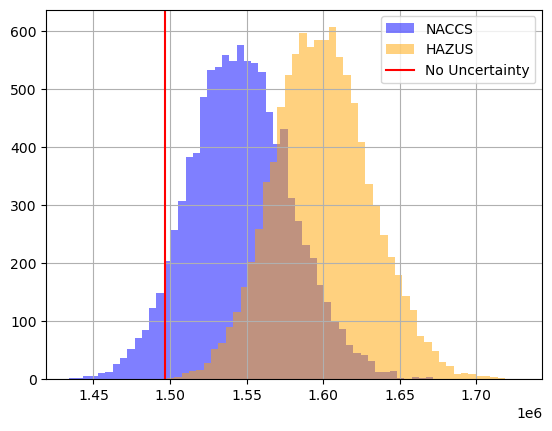

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
temp = ens_df_f.groupby(['sow_ind'])[['naccs_eal', 'hazus_eal']].sum()
temp['naccs_eal'].hist(bins=50, color='blue', alpha=.5, label='NACCS')
temp['hazus_eal'].hist(bins=50, color='orange', alpha=.5, label='HAZUS')
ax.axvline(nounc_df['eal'].sum(), color='red', label='No Uncertainty')
ax.legend()